# Assignment 1/A
**Disclaimer: Only for ADL/AML students!**

### General information
**You have to solve all tasks to pass!** 

Grade is calculated by the day of the last submission, but you will only get it after you've succesfully presented it. 

**Deadlines and grades:** 
  * 2020.09.20 - 2020.10.20 ==> 5
  * 2020.10.21 - 2020.10.27 ==> 4
  * 2020.10.28 - 2020.11.03 ==> 3
  * 2020.11.04 - 2020.11.10 ==> 2
  * 2020.11.11 or later ==> 1 

You can **use only these** 3rd party **packages:** `cv2, keras, matplotlib, numpy, sklearn, skimage, tensorflow`. (And `torchvision` for dowloading the dataset.)

### Description
In this assignment you have to build and train an airplane segmentation model using tf.keras. For architecture we will use a kind of autoencoder, called UNet. This kind of network has connections between the corresponding encoder and decoder layers. To implement such kind of models, you should take a look at the following classes and methods: `Funcitonal API, MaxPooling2D, concatenate, Conv2DTranspose`.

You can find some help in the following blog: 

https://towardsdatascience.com/cityscape-segmentation-with-tensorflow-2-0-b320b6605cbf

and its corresponding notebook: 

https://colab.research.google.com/drive/1i-7Vn_9hGdOvMjkYNedK5nsonNizhe0o?source=post_page-----b320b6605cbf----------------------


## Prepare dataset

* Download the PascalVOC2012 segmentation dataset. Here you can find more information about the labels: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/index.html *Hint: you don't need to load the data from scrach, you can iterate over the `data` variable, it will automatically read the image and the mask.*
* To see some samples, plot 5 random images and their corresponding labels.
* Crop each image to be an NxN image.
* Select only those, that contains aeroplanes and create a binary masks. *Note: you should get a binary image, where only aeroplane points are 255, others are 0.*
* Resize the images and the masks to 128x128. *Note: Do not use interpolation while resizing the mask.* 
* Split the datasets into train-val-test sets (ratio: 60-20-20), without shuffling.
* Print the size of each set and plot 5 training images and their corresponding masks.
* Normalize the datasets. Input values should be between -1.0 and 1.0, and targets should range between 0.0 and 1.0. *Note: you don't have to use standardization, you can just divide them by 255.*


In [57]:
pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [58]:
!mkdir -p ./voc2012
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=19Mh6P8sXJzD_j0O2AN_StB2fbqBXJNWA" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=19Mh6P8sXJzD_j0O2AN_StB2fbqBXJNWA" -o ./voc2012/VOCtrainval_11-May-2012.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2518      0 --:--:-- --:--:-- --:--:--  2518
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1907M    0 1907M    0     0  90.5M      0 --:--:--  0:00:21 --:--:-- 85.5M


In [59]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import torchvision

data = torchvision.datasets.VOCSegmentation('./voc2012/', year='2012', image_set='trainval', download=True)

Using downloaded and verified file: ./voc2012/VOCtrainval_11-May-2012.tar


<Figure size 432x288 with 0 Axes>

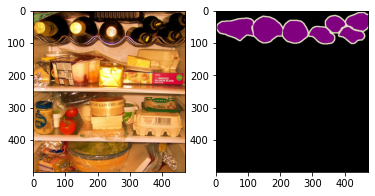

<Figure size 432x288 with 0 Axes>

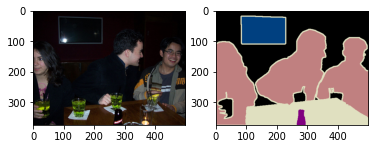

<Figure size 432x288 with 0 Axes>

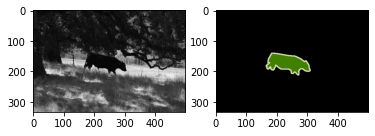

<Figure size 432x288 with 0 Axes>

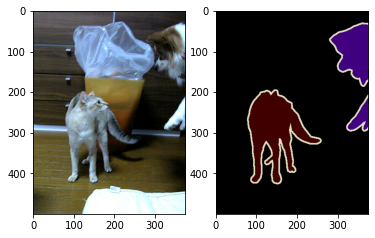

<Figure size 432x288 with 0 Axes>

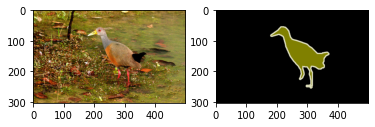

In [60]:
import random

n_images = 5

for i in range(n_images):
  plt.figure()
  f, axarr = plt.subplots(1,2)

  rand = random.randint(0, len(data)-1)
  
  axarr[0].imshow(data[rand][0])
  axarr[1].imshow(data[rand][1])

plt.show()

In [61]:
data[0][1].getcolors()

[(129545, 0), (4734, 1), (866, 15), (5355, 255)]

In [62]:
from PIL import Image

In [63]:
x_airplanes = []
y_airplanes = []
for item in data:
  if (1 in list(item[1].getdata())):
    x_airplanes.append(item[0])
    
    im = item[1].getdata()
    ni = np.array(im)
    mask = ni[:] == 1
    mask_target = Image.fromarray((mask*255).astype(np.uint8).reshape((item[1].height, item[1].width)))

    y_airplanes.append(mask_target)

<Figure size 432x288 with 0 Axes>

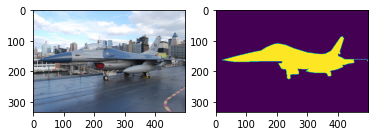

<Figure size 432x288 with 0 Axes>

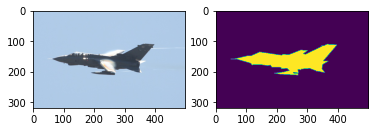

<Figure size 432x288 with 0 Axes>

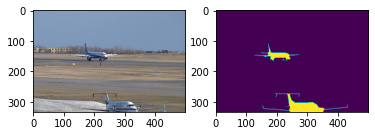

<Figure size 432x288 with 0 Axes>

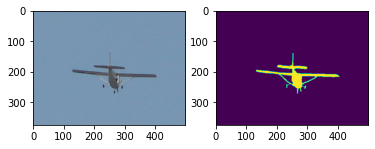

<Figure size 432x288 with 0 Axes>

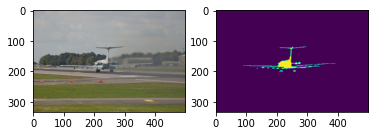

In [64]:
for i in range(n_images):
  plt.figure()
  f, axarr = plt.subplots(1,2)
  
  rand = random.randint(0, len(x_airplanes)-1)

  axarr[0].imshow(x_airplanes[rand])
  axarr[1].imshow(y_airplanes[rand])

plt.show()

In [65]:
from operator import attrgetter

max_width, max_height = max(x_airplanes, key=attrgetter('width')).width, max(x_airplanes, key=attrgetter('height')).height
min_width, min_height = min(x_airplanes, key=attrgetter('width')).width, min(x_airplanes, key=attrgetter('height')).height

print("Maximum width and height: {}, {}".format(max_width, max_height))
print("Minimum width and height: {}, {}".format(min_width, min_height))

Maximum width and height: 500, 500
Minimum width and height: 266, 175


In [66]:
def pad_image(im, desired_size, mode="RGB"):
  desired_size = max(desired_size)

  old_size = im.size

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])

  im = im.resize(new_size)

  new_im = Image.new(mode, (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
  return new_im

In [67]:
new_size = (128, 128)

x_airplanes_res = [item.crop(((item.width - min(item.width, item.height))/2, 
                              (item.height - min(item.width, item.height))/2, 
                              (item.width + min(item.width, item.height))/2, 
                              (item.height + min(item.width, item.height))/2)) for item in x_airplanes]
#x_airplanes_res = [pad_image(item, (max_width, max_height)) for item in x_airplanes]
x_airplanes_res = [item.resize(new_size) for item in x_airplanes_res]

y_airplanes_res = [item.crop(((item.width - min(item.width, item.height))/2, 
                              (item.height - min(item.width, item.height))/2, 
                              (item.width + min(item.width, item.height))/2, 
                              (item.height + min(item.width, item.height))/2)) for item in y_airplanes]
#y_airplanes_res = [pad_image(item, (max_width, max_height), "L") for item in y_airplanes]
y_airplanes_res = [item.resize(new_size) for item in y_airplanes_res]

In [68]:
from sklearn.model_selection import train_test_split

x_airplanes_narray = [np.array(item) for item in x_airplanes_res]
y_airplanes_narray = [np.expand_dims(np.array(item), axis=2) for item in y_airplanes_res]

x_airplanes_narray = np.stack(x_airplanes_narray, axis=0)
y_airplanes_narray = np.stack(y_airplanes_narray, axis=0)

# Split the data into 60 20 20
x_train, x_test, y_train, y_test = train_test_split(x_airplanes_narray, y_airplanes_narray, test_size=0.4, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

In [69]:
print('Training set size:', x_train.shape)
print('Training labels size:', y_train.shape)
print('Validation set size:', x_val.shape)
print('Validation labels size:', y_val.shape)
print('Test set size:', x_test.shape)
print('Test labels size:', y_test.shape)

Training set size: (106, 128, 128, 3)
Training labels size: (106, 128, 128, 1)
Validation set size: (36, 128, 128, 3)
Validation labels size: (36, 128, 128, 1)
Test set size: (36, 128, 128, 3)
Test labels size: (36, 128, 128, 1)


<Figure size 432x288 with 0 Axes>

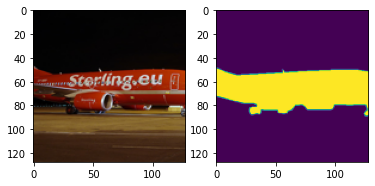

<Figure size 432x288 with 0 Axes>

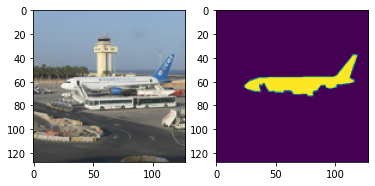

<Figure size 432x288 with 0 Axes>

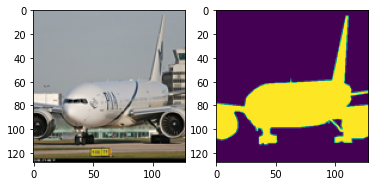

<Figure size 432x288 with 0 Axes>

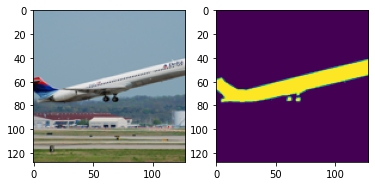

<Figure size 432x288 with 0 Axes>

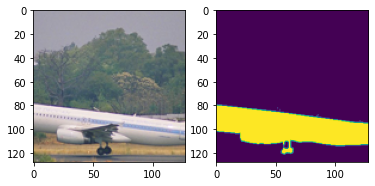

In [70]:
for i in range(n_images):
  plt.figure()
  f, axarr = plt.subplots(1,2)
  
  rand = random.randint(0, len(x_train)-1)

  axarr[0].imshow(x_train[rand])
  axarr[1].imshow(y_train[rand].reshape(128,128))

plt.show()

In [71]:
x_train_norm = (x_train / 127.5) - 1
y_train_norm = y_train / 255.0

x_val_norm = (x_val / 127.5) - 1
y_val_norm = y_val / 255.0

x_test_norm = (x_test / 127.5) - 1
y_test_norm = y_test / 255.0

## Data augmentation
  * Augment the training set using `ImageDataGenerator`. The parameters should be the following: `featurewise_center=False, featurewise_std_normalization=False, rotation_range=90., width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True`.
  * When creating the generator(s), use shuffling with a seed value of 1 and batch size of 32.
  * To validate that the augmentation is working, plot 5 original images with their corresponding transformed (augmented) images and masks.

**Keep in mind:** To augment the inputs and targets the same way, you should create 2 separate generator, then you can zip them together. 


In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed = 1

data_gen_args = dict(featurewise_center=False,
                      featurewise_std_normalization=False,
                      rotation_range=90,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      zoom_range=0.2,
                      horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args) 
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(x_train_norm, augment=True, seed=seed) 
mask_datagen.fit(y_train_norm, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train_norm, y_train_norm, batch_size=32, shuffle=True, seed=seed)
mask_generator = mask_datagen.flow(y_train_norm, x_train_norm, batch_size=32, shuffle=True, seed=seed)

def myGenerator(train_generator,train_generator1):
    while True:
        xy = train_generator.next()
        xy1 = train_generator1.next()
        yield (xy[0],xy1[0])

# combine generators into one which yields image and masks
#train_generator = zip(image_generator, mask_generator)
train_generator = myGenerator(image_generator, mask_generator)

In [73]:
x_batch, y_batch = next(train_generator)

<Figure size 432x288 with 0 Axes>

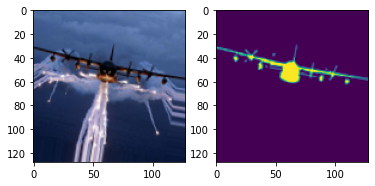

<Figure size 432x288 with 0 Axes>

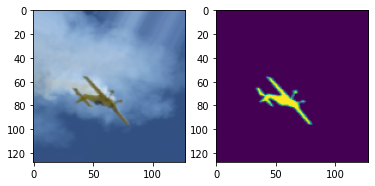

<Figure size 432x288 with 0 Axes>

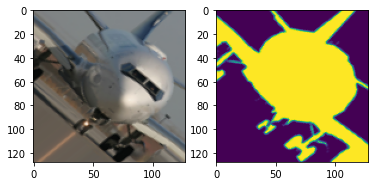

<Figure size 432x288 with 0 Axes>

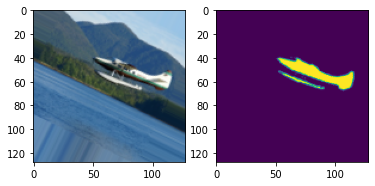

<Figure size 432x288 with 0 Axes>

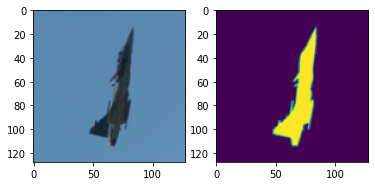

In [74]:
for i in range(n_images):
  plt.figure()
  f, axarr = plt.subplots(1,2)
  
  axarr[0].imshow(((x_batch[i] + 1) * 127.5).astype(np.uint8))
  axarr[1].imshow(y_batch[i].reshape(128,128))

plt.show()

## Define the model
Define a UNet model in tf.keras. The architecture should look similar to the one in [blog/notebook](https://colab.research.google.com/drive/1i-7Vn_9hGdOvMjkYNedK5nsonNizhe0o?source=post_page-----b320b6605cbf----------------------), but smaller by 2 stages.

You can see the exact architecture on the figure below. 
* Use `padding='same'` for each layer and use `Conv2DTranspose` layers to upscale the results. 
* For optimizer use Adam, and add accuracy to the metrics.

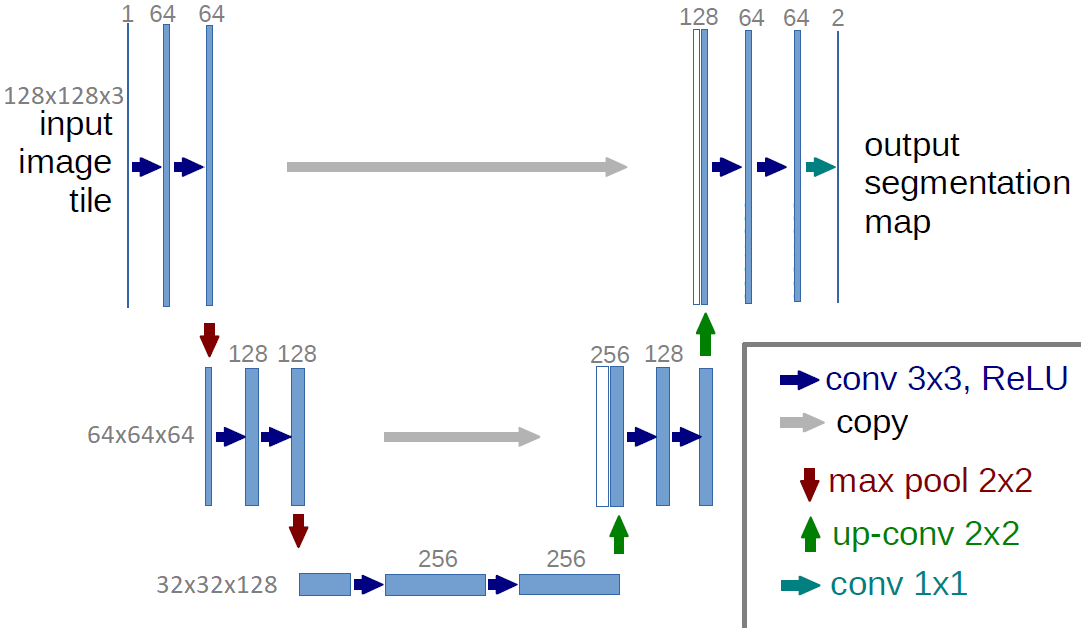

In [75]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [76]:
def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    upconv4 = Conv2DTranspose(256, 2, padding='same', strides=(2,2), activation=None, kernel_initializer='he_normal')(conv3)
    merge4 = concatenate([conv2 ,upconv4], axis = 3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upconv4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    upconv5 = Conv2DTranspose(128, 2, padding='same', strides=(2,2), activation=None, kernel_initializer='he_normal')(conv4)
    merge5 = concatenate([conv1 ,upconv5], axis = 3)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upconv5)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, 1, activation = 'sigmoid')(conv5)

    model = tf.keras.Model(inputs, conv6)

    return model

model = unet(input_size=(128, 128, 3))

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)      

## Training and evaluation 
  * Train the model for 50 epochs and use early stopping with patience of 10.
  * Plot the training curve (train/validation loss and train/validation accuracy).
  * Evaluate the trained model on the test set and plot some (5) predictions with their corresponding GT masks.

In [77]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [78]:
y_train_norm.shape

(106, 128, 128, 1)

In [79]:
batch_size = 32

earlystopper = EarlyStopping(patience=10, verbose=1)

#history = model.fit(x_train_norm, y_train_norm, batch_size, epochs=50, 
#                    validation_data=(x_val_norm, y_val_norm), verbose=1, callbacks=[earlystopper])

history = model.fit(train_generator, validation_data=(x_val_norm, y_val_norm), steps_per_epoch=150, epochs=50, callbacks=[earlystopper])

Epoch 1/50
150/150 [==============================] - 65s 432ms/step - loss: 0.3388 - accuracy: 0.8198 - val_loss: 0.2509 - val_accuracy: 0.8738
Epoch 2/50
150/150 [==============================] - 65s 435ms/step - loss: 0.2422 - accuracy: 0.8544 - val_loss: 0.2399 - val_accuracy: 0.8795
Epoch 3/50
150/150 [==============================] - 65s 437ms/step - loss: 0.2182 - accuracy: 0.8664 - val_loss: 0.2569 - val_accuracy: 0.8678
Epoch 4/50
150/150 [==============================] - 66s 438ms/step - loss: 0.1979 - accuracy: 0.8764 - val_loss: 0.2302 - val_accuracy: 0.8776
Epoch 5/50
150/150 [==============================] - 66s 437ms/step - loss: 0.1775 - accuracy: 0.8863 - val_loss: 0.2600 - val_accuracy: 0.8751
Epoch 6/50
150/150 [==============================] - 66s 438ms/step - loss: 0.1694 - accuracy: 0.8904 - val_loss: 0.2512 - val_accuracy: 0.8748
Epoch 7/50
150/150 [==============================] - 65s 436ms/step - loss: 0.1637 - accuracy: 0.8933 - val_loss: 0.2481 - val_ac

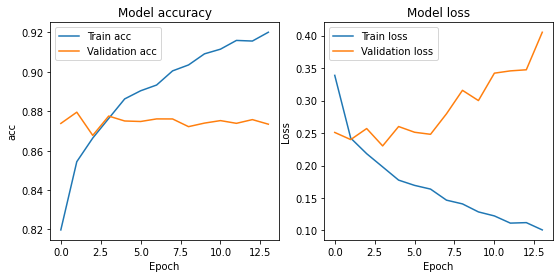

In [80]:
# Plot training & validation mse values
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

In [81]:
score = model.evaluate(x_test_norm, y_test_norm, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.400284081697464
Test accuracy: 0.8740861415863037


In [82]:
pred = model.predict(x_test_norm) 

<Figure size 432x288 with 0 Axes>

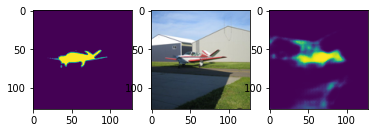

<Figure size 432x288 with 0 Axes>

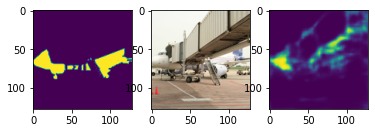

<Figure size 432x288 with 0 Axes>

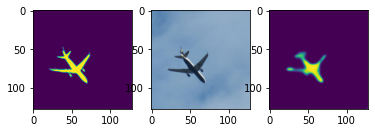

<Figure size 432x288 with 0 Axes>

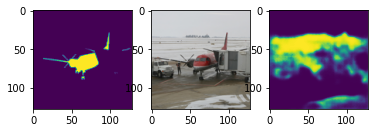

<Figure size 432x288 with 0 Axes>

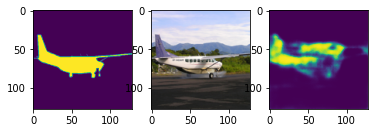

In [83]:
for i in range(n_images):
  plt.figure()
  f, axarr = plt.subplots(1,3)

  r = random.randint(0, len(x_test) - 1)
  
  axarr[0].imshow(y_test[r].reshape(128,128))
  axarr[1].imshow(x_test[r])
  axarr[2].imshow(pred[r].reshape(128,128))

plt.show()